In [1]:
import numpy as np
import pandas as pds
import os

import matplotlib as MP
from matplotlib import pyplot as plt
import seaborn as sbn

data = pds.read_csv(
    '../files/week06/Week 06. data-wine-red.csv',
    delimiter=';'
)

print(data.quality.value_counts())
data.quality -= 3

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64


In [2]:
from itertools import product
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier as KNC

def ss_kfold_fn(data, scaling = True):
    kf = StratifiedKFold()
    for n, (train_idx, valid_idx) in enumerate(kf.split(data, data.quality)):
        
        scaler_x = StandardScaler()
        
        if scaling:
            train_x = scaler_x.fit_transform(data.iloc[train_idx].drop(columns = 'quality'))
            valid_x = scaler_x.transform(data.iloc[valid_idx].drop(columns = 'quality'))
            
        else:
            train_x = data.iloc[train_idx].drop(columns = 'quality').values
            valid_x = data.iloc[valid_idx].drop(columns = 'quality').values

        train_y = data.iloc[train_idx]['quality'].values.reshape(-1,1)
        valid_y = data.iloc[valid_idx]['quality'].values.reshape(-1,1)
        
        yield [
            [train_x, train_y],
            [valid_x, valid_y]
        ], (scaler_x)


In [16]:
model = KNC( n_neighbors = 7, weights = 'distance')

scalers = []
valid_y_hat = []
valid_y = []
for (train_set, valid_set), scaler in ss_kfold_fn(data, True):
    scalers.append(scaler)
    model.fit(train_set[0], train_set[1].ravel())
    valid_y.append(valid_set[1].squeeze())
    valid_y_hat.append(model.predict_proba(valid_set[0]).squeeze())

In [4]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report

In [17]:
for y_true, y_predict in zip(valid_y, valid_y_hat):
    print(classification_report(y_true, y_predict.argmax(1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.53      0.67      0.59       137
           3       0.45      0.42      0.43       127
           4       0.36      0.20      0.26        40
           5       0.00      0.00      0.00         3

    accuracy                           0.48       320
   macro avg       0.22      0.21      0.21       320
weighted avg       0.45      0.48      0.46       320

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        10
           2       0.64      0.60      0.62       136
           3       0.51      0.61      0.55       128
           4       0.47      0.42      0.45        40
           5       1.00      0.25      0.40         4

    accuracy                           0.56       320
   macro avg       0.44

Fold: 0 precision: 0.4486 recall: 0.4781
Fold: 1 precision: 0.5443 recall: 0.5563
Fold: 2 precision: 0.6209 recall: 0.6219
Fold: 3 precision: 0.5007 recall: 0.5000
Fold: 4 precision: 0.5217 recall: 0.5141


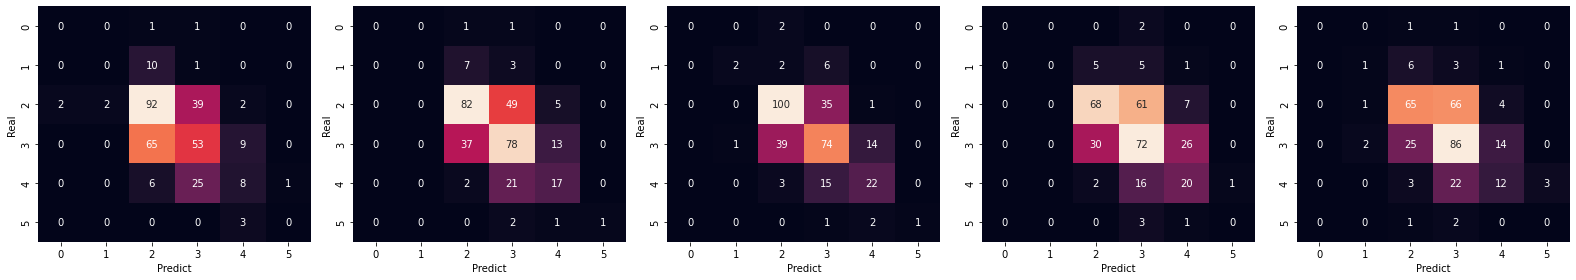

In [18]:
from matplotlib import pyplot as plt
import seaborn as sbn
import warnings

warnings.filterwarnings('ignore')

fig, ax = plt.subplots(1,5,figsize = (22, 4))
for n, (yt, yp) in enumerate(zip(valid_y, valid_y_hat)):
    conf = confusion_matrix(yt, yp.argmax(1))
    sbn.heatmap(conf, ax = ax[n], annot = conf, fmt='.4g', cbar = False)
    ax[n].set_ylabel('Real')
    ax[n].set_xlabel('Predict')
    
    P = precision_score(yt, yp.argmax(1), average='weighted')
    R = recall_score(yt, yp.argmax(1), average='weighted')
    print('Fold: {} precision: {:.4f} recall: {:.4f}'.format(n,P,R))
    
fig.tight_layout()